# Transfer Learning

Transfer learning is a machine learning technique where a model trained on one task  is re-purposed on a second related task.

**Pre-trained Model Approach**

1. Select Source Model. A pre-trained source model is chosen from available models. Many research institutions release models on large and challenging datasets that may be included in the pool of candidate models from which to choose from.

2. Reuse Model. The model pre-trained model can then be used as the starting point for a model on the second task of interest. This may involve using all or parts of the model, depending on the modeling technique used.

3. Tune Model. Optionally, the model may need to be adapted or refined on the input-output pair data available for the task of interest.



# Credits

https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
    
https://www.tensorflow.org/tutorials/images/classification
    
https://codebasics.io/courses/deep-learning-with-tensorflow-keras-and-python
    
https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4

# VGG-16
Objective: The ImageNet dataset contains images of fixed size of 224*224 and have RGB channels. So, we have a tensor of (224, 224, 3) as our input. This model process the input image and outputs the a vector of 1000 values.

**VGG Architecture:**
The input to the network is an image of dimensions (224, 224, 3). The first two layers have 64 channels of a 3X3 filter size and the same padding. Then after a max pool layer of stride (2, 2), two layers have convolution layers of 128 filter size and filter size (3, 3). This is followed by a max-pooling layer of stride (2, 2) which is the same as the previous layer. Then there are 2 convolution layers of filter size (3, 3) and 256 filters. After that, there are 2 sets of 3 convolution layers and a max pool layer. Each has 512 filters of (3, 3) size with the same padding. 

This image is then passed to the stack of two convolution layers. In these convolution and max-pooling layers, the filters we use are of the size 3X3 instead of 11X11 in AlexNet and 7X7 in ZF-Net. In some of the layers, it also uses 1X1 pixel which is used to manipulate the number of input channels. There is a padding of 1-pixel (same padding) done after each convolution layer to prevent the spatial feature of the image.


# 1.Import Python modules

In [1]:
import numpy as np
import cv2
import os

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

# 2. Load trained model

In [2]:
IMAGE_SHAPE = (224, 224)

# load model
model = VGG16()
# summarize the model
model.summary()

553476096/553467096 [==============================] - 18s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [3]:
# remove the output layer
model = VGG16(include_top=False, input_shape=(224, 224, 3))
model.summary()

58900480/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [4]:
flat1 = Flatten()(model.layers[-1].output)
#class1 = Dense(1024, activation='relu')(flat1)
output = Dense(5, activation='softmax')(flat1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
for layer in model.layers[:20]:
    layer.trainable = False

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# 3.Load flowers dataset

In [7]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228827136/228813984 [==============================] - 8s 0us/step


In [8]:
data_dir

'./datasets/flower_photos'

In [9]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

# 4.Read flowers images from disk into numpy array using opencv

In [10]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [11]:
num_of_flowers = 5
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [12]:
X, Y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        Y.append(flowers_labels_dict[flower_name])

In [13]:
X = np.array(X)
Y = np.array(Y)

# 5.Train test split

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

# 6. Preprocessing: scale images

In [15]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

# 7.Now take pre-trained model and retrain it using flowers images

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history=model.fit(X_train_scaled, Y_train, validation_split=0.2,epochs=5)

Epoch 1/5
69/69 [==============================] - 20s 140ms/step - loss: 0.9442 - accuracy: 0.6756 - val_loss: 0.5832 - val_accuracy: 0.7804
Epoch 2/5
69/69 [==============================] - 5s 79ms/step - loss: 0.3077 - accuracy: 0.9041 - val_loss: 0.4992 - val_accuracy: 0.8167
Epoch 3/5
69/69 [==============================] - 5s 78ms/step - loss: 0.1533 - accuracy: 0.9591 - val_loss: 0.4952 - val_accuracy: 0.8185
Epoch 4/5
69/69 [==============================] - 5s 79ms/step - loss: 0.0856 - accuracy: 0.9905 - val_loss: 0.5027 - val_accuracy: 0.8149
Epoch 5/5
69/69 [==============================] - 5s 79ms/step - loss: 0.0522 - accuracy: 0.9968 - val_loss: 0.4580 - val_accuracy: 0.8385


In [18]:
model.evaluate(X_test_scaled,Y_test)

29/29 [==============================] - 4s 137ms/step - loss: 0.4031 - accuracy: 0.8638


[0.4031243324279785, 0.8638344407081604]

# 8.Evaluate the model

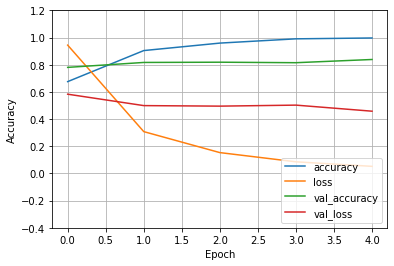

In [19]:
plt.grid()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([-0.4, 1.2])
plt.legend(loc='lower right')
plt.show()

# 9. Summary
1. https://www.kaggle.com/code/alexreddy/data-augmentation-in-cnn  train accuracy: 0.88, 
test accuracy:0.73, with Epochs 30
2. In this model(Transfer Learning using VGG-16) - train accuracy: 0.99, test accuracy:0.83, with 5 Epochs - (16% difference between train and test accuracy) overfitting
